In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, img_size = 299,
                                               mean_proc=None, test_size=0.1)

# Xception Fine Tuning

In [3]:
model_name = 'Xception-Fine-Tune'

img_rows, img_cols, img_channel = 299, 299, 3
base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

83689472/83683744 [==============================] - 81s 1us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 10
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 269 steps, validate on 299 samples
Epoch 1/100
268/269 [============================>.] - ETA: 0s - loss: 2.4769 - accuracy: 0.2096
Epoch 00001: val_loss improved from inf to 2.17968, saving model to ./saved_models/Xception-Fine-Tune.h5
269/269 [==============================] - 143s 533ms/step - loss: 2.4747 - accuracy: 0.2111 - val_loss: 2.1797 - val_accuracy: 0.4649
Epoch 2/100
268/269 [============================>.] - ETA: 0s - loss: 1.7632 - accuracy: 0.5964
Epoch 00002: val_loss improved from 2.17968 to 1.44835, saving model to ./saved_models/Xception-Fine-Tune.h5
269/269 [==============================] - 136s 507ms/step - loss: 1.7616 - accuracy: 0.5975 - val_loss: 1.4484 - val_accuracy: 0.7458
Epoch 3/100
268/269 [============================>.] - ETA: 0s - loss: 1.1823 - accuracy: 0.7436
Epoch 00003: val_loss improved from 1.44835 to 0.79391, saving model to ./saved

268/269 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9996
Epoch 00025: val_loss did not improve from 0.07865
269/269 [==============================] - 135s 500ms/step - loss: 0.0134 - accuracy: 0.9996 - val_loss: 0.0920 - val_accuracy: 0.9732
Epoch 26/100
268/269 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000
Epoch 00026: val_loss did not improve from 0.07865
269/269 [==============================] - 134s 500ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9766
Epoch 00026: early stopping


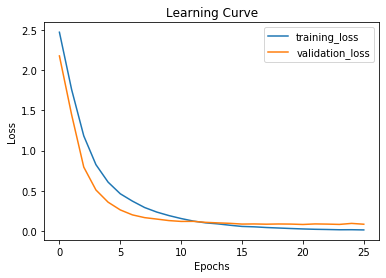

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

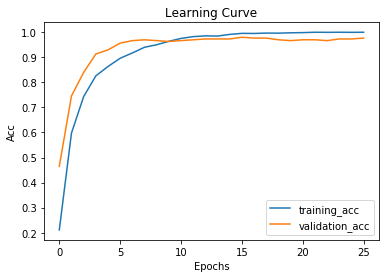

In [7]:
training_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [8]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None, img_size=299)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 5s 16ms/sample - loss: 0.0787 - accuracy: 0.9699
Validation loss: 0.07865465930772067
Validation accuracy: 0.96989965
